In [39]:
import dgl
import dgl.function as fn

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

In [2]:
import pickle

# Load the training and validation molecules.
train_path = "data/zinc_250k_train.pkl"
valid_path = "data/zinc_250k_valid.pkl"

with open(train_path, "rb") as f:
    train_graphs = pickle.load(f)

with open(valid_path, "rb") as f:
    valid_graphs = pickle.load(f)

In [3]:
from utils import to_dgl_graph

# Turn the molecules into DGLGraph, so as to train a model with the Deep Graph Library (DGL).
train_dataset = []
valid_dataset = []

for graph in train_graphs:
    train_dataset.append(to_dgl_graph(graph))

for graph in valid_graphs:
    valid_dataset.append(to_dgl_graph(graph))

nb_node_types = 14
nb_edge_types = 3

RDKit WARNING: [19:11:24] Enabling RDKit 2019.09.3 jupyter extensions


In [9]:
from torch.utils.data import DataLoader

# Create mini-batches
batch_size = 64

def collate(samples):
    return dgl.batch(samples)

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate)

In [32]:
import model
import importlib
importlib.reload(model)

from model import VGAE

# Create the model and the optimizer
n_epochs = 1
lr = 0.01
kl_loss_lambda = 0.1

model = VGAE(nb_node_types, nb_edge_types)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model)

VGAE(
  (conv1): RelGraphConv(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (conv2): RelGraphConv(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (conv_mu): RelGraphConv(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (conv_logstd): RelGraphConv(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (node_types_fc): Linear(in_features=128, out_features=14, bias=True)
  (edge_existence_fc): Linear(in_features=412, out_features=1, bias=True)
  (edge_types_fc): Linear(in_features=412, out_features=3, bias=True)
)


In [33]:
import utils
import importlib
importlib.reload(utils)

from tqdm import tqdm
from utils import recon_loss, kl_loss

def eval(dataloader, model):
    eval_recon_loss = 0
    eval_kl_loss = 0
    model.eval()

    with torch.no_grad():
        for bg in tqdm(dataloader):
            n_features = bg.ndata["feats"]
            e_types = bg.edata["type"]
            pred_graphs, mu, logstd = model(bg, n_features, e_types)

            eval_recon_loss += recon_loss(pred_graphs, dgl.unbatch(bg)).item()
            eval_kl_loss += kl_loss(mu, logstd).item()

    model.train()
    return eval_recon_loss / len(dataloader), eval_kl_loss / len(dataloader)

# Train the model 
recon_loss_history = []
kl_loss_history = []

for epoch in range(n_epochs):
    train_loss = 0
    model.train()

    for bg in tqdm(train_loader):
        n_features = bg.ndata["feats"]
        e_types = bg.edata["type"]
        pred_graphs, mu, logstd = model(bg, n_features, e_types)

        train_recon_loss = recon_loss(pred_graphs, dgl.unbatch(bg))
        train_kl_loss = kl_loss(mu, logstd)
        loss = train_recon_loss + kl_loss_lambda * train_kl_loss

        recon_loss_history.append(train_recon_loss.item())
        kl_loss_history.append(train_kl_loss.item())
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    valid_recon_loss, valid_kl_loss = eval(valid_loader, model)
        
    print("Epoch {}, train_loss: {:,.3f}, valid_recon_loss: {:,.3f}, valid_kl_loss: {:,.3f}".format(epoch, train_loss, valid_recon_loss, valid_kl_loss))

100%|██████████| 389/389 [12:33<00:00,  1.94s/it]Epoch 0, train_loss: 1.077, valid_recon_loss: 0.713, valid_kl_loss: 2.960



In [42]:
print("Training reconstruction loss :", np.mean(recon_loss_history))
print("Training KL loss :", np.mean(kl_loss_history))
print("")

print("Validation reconstruction loss :", valid_recon_loss)
print("Validation KL loss :", valid_kl_loss)

Training reconstruction loss : 0.7722094542298998
Training KL loss : 3.0520772952352253

Validation reconstruction loss : 0.7125513285475096
Validation KL loss : 2.9599912908205948


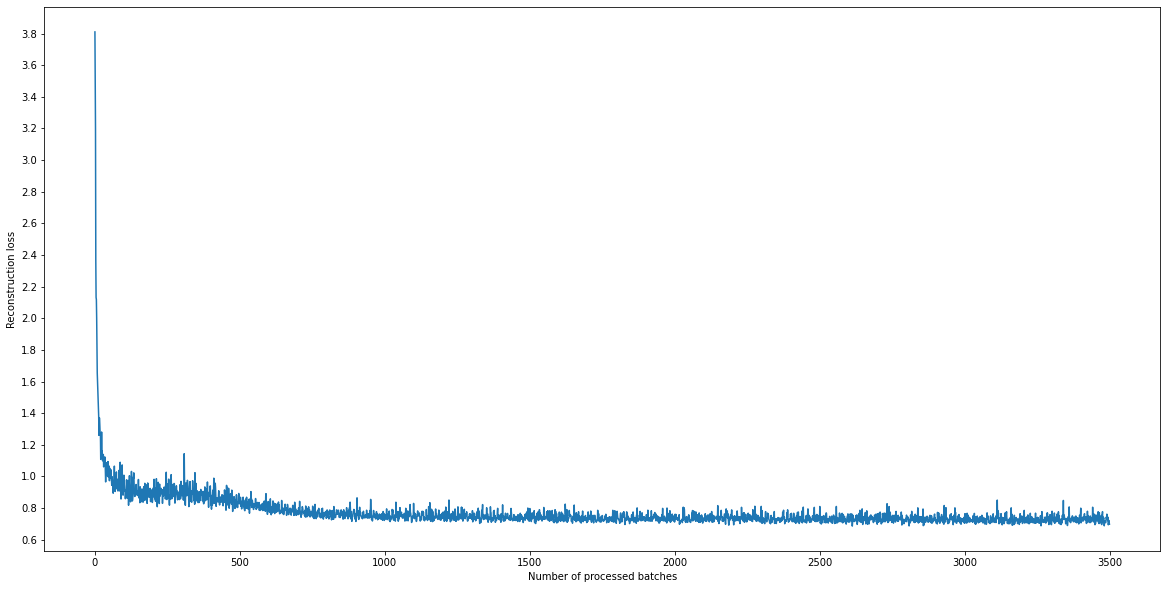

In [47]:
# Plot training reconstruction loss
plt.ylabel('Reconstruction loss')
plt.xlabel('Number of processed batches')
plt.yticks(np.arange(0, 4, step=0.2))
plt.plot(recon_loss_history)

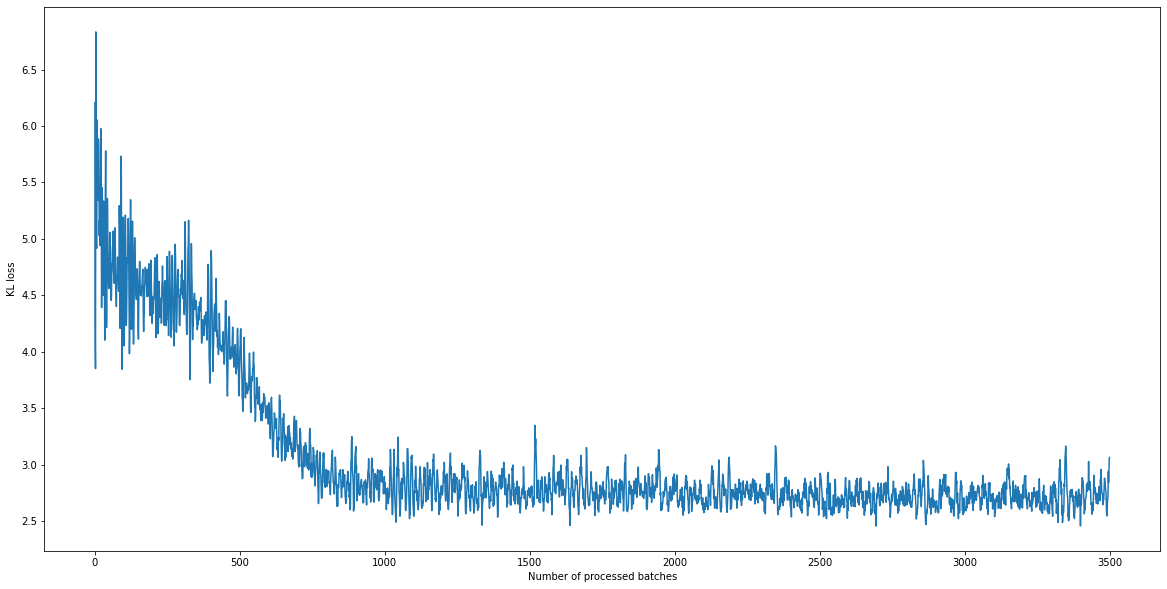

In [48]:
# Plot training KL loss
plt.ylabel('KL loss')
plt.xlabel('Number of processed batches')
plt.yticks(np.arange(0, 7, step=0.5))
plt.plot(kl_loss_history)

In [36]:
# Save model to disk
torch.save(model.state_dict(), "trained_model.pkl")